# Making a new hybrid grid file

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr



### function to emulate the FNC1 function in MOM6

In [1]:
def fnc1(dz_min, h_total, power, nk):
    dz=np.zeros(nk)
    
    for k in range(nk):
        dz[k] = ((k)/(nk))**power
        
    dz = ( h_total - (nk) * dz_min ) * ( dz / np.sum(dz) ) #! Rescale to so total is H_total
    dz[-1] = dz[-1] + ( h_total - np.sum( dz + dz_min ) ) #! Adjust bottommost layer
    dz = dz + dz_min #! Finally add in the constant dz_min
    
    return dz

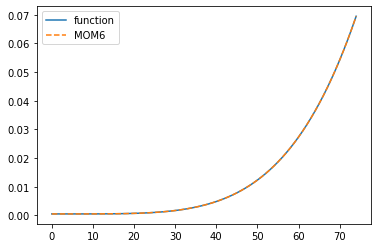

In [40]:
#Testing against MOM output using FNC1:0.0005,1,4.5,0.000001 with 75 layers
dz_sigma = fnc1(0.0005,1,4.5,75)
plt.plot(dz_sigma,label='function')

ds = xr.open_dataset('/g/data/x77/amh157/anu-tub/outputs/anu-tub-sig-hotstart/output293/Vertical_coordinate.nc')
plt.plot(ds.Interface.diff('Interface'),linestyle='--',label='MOM6')

plt.legend();

### creating a new sigma coordinate

Here we are aiming for something that has similar surface resolution, but resolves the bottom pretty well. Using an offset Gaussian...

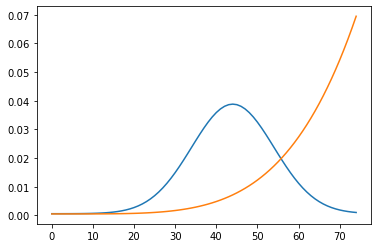

In [63]:
dz_sigma_new = np.zeros(75)
z = np.linspace(1,75,75)
dz_sigma_new = np.exp(-0.005*(z-45)**2)+0.015
dz_sigma_new = dz_sigma_new/np.sum(dz_sigma_new)
plt.plot(dz_sigma_new)
plt.plot(dz_sigma,label='function')



In [82]:
st_edges_sigma = np.zeros(76)
st_edges_sigma[1:] = np.cumsum(dz_sigma_new)

## Open existing vcoord file

This is the file that is used in the zstar panant case with the arguments:

`ALE_COORDINATE_CONFIG = "FILE:vcoord.nc,interfaces=st_edges_ocean"`

Let's look at that file and see what it looks like.

In [18]:
ds_vcoord = xr.open_dataset("/g/data/x77/ahg157/inputs/mom6/panan/vcoord.nc")

In [76]:
ds_vcoord.st_edges_ocean

<xarray.DataArray 'st_edges_ocean' (st_edges_ocean: 76)>
array([0.000000e+00, 1.082562e+00, 2.278908e+00, 3.600997e+00, 5.062046e+00,
       6.676655e+00, 8.460964e+00, 1.043281e+01, 1.261188e+01, 1.501997e+01,
       1.768113e+01, 2.062195e+01, 2.387179e+01, 2.746312e+01, 3.143179e+01,
       3.581741e+01, 4.066373e+01, 4.601908e+01, 5.193684e+01, 5.847596e+01,
       6.570151e+01, 7.368533e+01, 8.250670e+01, 9.225307e+01, 1.030209e+02,
       1.149166e+02, 1.280572e+02, 1.425717e+02, 1.586020e+02, 1.763040e+02,
       1.958489e+02, 2.174242e+02, 2.412350e+02, 2.675053e+02, 2.964787e+02,
       3.284196e+02, 3.636136e+02, 4.023675e+02, 4.450091e+02, 4.918859e+02,
       5.433625e+02, 5.998174e+02, 6.616377e+02, 7.292120e+02, 8.029216e+02,
       8.831294e+02, 9.701670e+02, 1.064320e+03, 1.165816e+03, 1.274803e+03,
       1.391349e+03, 1.515420e+03, 1.646887e+03, 1.785522e+03, 1.931006e+03,
       2.082944e+03, 2.240881e+03, 2.404321e+03, 2.572745e+03, 2.745633e+03,
       2.922475e+03, 3.102788e+03, 3.286119e+03, 3.472058e+03, 3.660233e+03,
       3.850315e+03, 4.042017e+03, 4.235086e+03, 4.429308e+03, 4.624497e+03,
       4.820497e+03, 5.017173e+03, 5.214414e+03, 5.412126e+03, 5.610229e+03,
       5.808657e+03])
Coordinates:
  * st_edges_ocean  (st_edges_ocean) float64 0.0 1.083 ... 5.61e+03 5.809e+03
Attributes:
    long_name:       tcell zstar depth edges
    units:           meters
    cartesian_axis:  Z
    positive:        down

In [123]:
stds  = xr.Dataset({'st_edges_sigma':(['st_edges_sigma'], st_edges_sigma)})


stds['st_edges_sigma'].attrs = {'long_name':'tcell zstar depth edges','units':'nondim',
                            'cartesian_axis': 'Z','positive': 'down'}

stds.to_netcdf('/g/data/x77/amh157/mom6/input/anu-tub/st_edges_sigma.nc')

In [120]:
ds1 = xr.open_dataset('/g/data/x77/amh157/mom6/input/anu-tub/st_edges_sigma.nc')

In [122]:
ds1.st_edges_sigma

<xarray.DataArray 'st_edges_sigma' (interfaces: 76)>
array([0.000000e+00, 5.757269e-04, 1.152756e-03, 1.731741e-03, 2.313630e-03,
       2.899789e-03, 3.492159e-03, 4.093468e-03, 4.707503e-03, 5.339466e-03,
       5.996415e-03, 6.687810e-03, 7.426186e-03, 8.227942e-03, 9.114271e-03,
       1.011222e-02, 1.125587e-02, 1.258758e-02, 1.415934e-02, 1.603406e-02,
       1.828677e-02, 2.100572e-02, 2.429306e-02, 2.826520e-02, 3.305259e-02,
       3.879877e-02, 4.565873e-02, 5.379625e-02, 6.338038e-02, 7.458099e-02,
       8.756335e-02, 1.024820e-01, 1.194741e-01, 1.386523e-01, 1.600980e-01,
       1.838544e-01, 2.099212e-01, 2.382498e-01, 2.687400e-01, 3.012395e-01,
       3.355440e-01, 3.714012e-01, 4.085151e-01, 4.465540e-01, 4.851592e-01,
       5.239550e-01, 5.625602e-01, 6.005992e-01, 6.377131e-01, 6.735702e-01,
       7.078748e-01, 7.403742e-01, 7.708645e-01, 7.991930e-01, 8.252599e-01,
       8.490163e-01, 8.704620e-01, 8.896402e-01, 9.066323e-01, 9.215509e-01,
       9.345333e-01, 9.457339e-01, 9.553180e-01, 9.634555e-01, 9.703155e-01,
       9.760617e-01, 9.808491e-01, 9.848212e-01, 9.881086e-01, 9.908275e-01,
       9.930802e-01, 9.949549e-01, 9.965267e-01, 9.978584e-01, 9.990020e-01,
       1.000000e+00])
Coordinates:
  * interfaces  (interfaces) float64 0.0 0.0005757 0.001153 ... 0.9979 0.999 1.0

## Will this work? 

I think it will, if we can use:

`ALE_COORDINATE_CONFIG = "FILE:st_edges_sigma.nc,interfaces=st_edges_sigma"`



In [119]:
stds.st_edges_sigma

<xarray.DataArray 'st_edges_sigma' (st_edges_sigma: 76)>
array([0.000000e+00, 5.757269e-04, 1.152756e-03, 1.731741e-03, 2.313630e-03,
       2.899789e-03, 3.492159e-03, 4.093468e-03, 4.707503e-03, 5.339466e-03,
       5.996415e-03, 6.687810e-03, 7.426186e-03, 8.227942e-03, 9.114271e-03,
       1.011222e-02, 1.125587e-02, 1.258758e-02, 1.415934e-02, 1.603406e-02,
       1.828677e-02, 2.100572e-02, 2.429306e-02, 2.826520e-02, 3.305259e-02,
       3.879877e-02, 4.565873e-02, 5.379625e-02, 6.338038e-02, 7.458099e-02,
       8.756335e-02, 1.024820e-01, 1.194741e-01, 1.386523e-01, 1.600980e-01,
       1.838544e-01, 2.099212e-01, 2.382498e-01, 2.687400e-01, 3.012395e-01,
       3.355440e-01, 3.714012e-01, 4.085151e-01, 4.465540e-01, 4.851592e-01,
       5.239550e-01, 5.625602e-01, 6.005992e-01, 6.377131e-01, 6.735702e-01,
       7.078748e-01, 7.403742e-01, 7.708645e-01, 7.991930e-01, 8.252599e-01,
       8.490163e-01, 8.704620e-01, 8.896402e-01, 9.066323e-01, 9.215509e-01,
       9.345333e-01, 9.457339e-01, 9.553180e-01, 9.634555e-01, 9.703155e-01,
       9.760617e-01, 9.808491e-01, 9.848212e-01, 9.881086e-01, 9.908275e-01,
       9.930802e-01, 9.949549e-01, 9.965267e-01, 9.978584e-01, 9.990020e-01,
       1.000000e+00])
Coordinates:
  * st_edges_sigma  (st_edges_sigma) float64 0.0 0.0005757 ... 0.999 1.0
Attributes:
    long_name:       tcell zstar depth edges
    units:           
    cartesian_axis:  Z
    positive:        down